Outlier Detection with DBSCAN

# DBSCAN Örnek

In [4]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

Generate sample data

In [5]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

In [ ]:
# Plot the data

In [7]:
X = StandardScaler().fit_transform(X)

DBSCAN algorithm will applied to generated data

In [4]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


Plot algorithm result

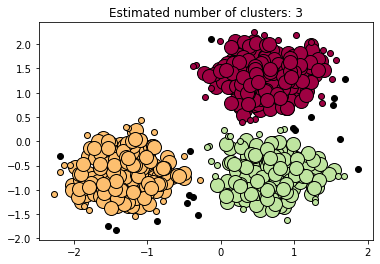

In [5]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## İşlem Adımları

a - Download AIS Data (https://web.ais.dk/aisdata/)

b - Zones data download

1 - Connect to Database

2 - Create Table

3 - Import data to Database

4 - Add Postgis Extension

5 - Create Geom column

6 - Set Geom Column

c - Indeksleme işlemi yapılması önerilir

7 - Trip time determination

8 - Find Optimum Espilon Value

9 - Apply DBSCAN

10 - Export to CSV

## 1 - Connect to database

In [1]:
import psycopg2

def connectToDatabase(database,user,password,host,port):
    try:
        conn = psycopg2.connect(database=database,
                                    user=user,
                                    password=password,
                                    host=host,
                                    port=port)
        #cur = conn.cursor()
        return conn
    except:
        return False

In [3]:
connection = connectToDatabase('trajectory','postgres','1234','localhost','5433')
print (connection)

<connection object at 0x0000024AFE1F2150; dsn: 'user=postgres password=xxx dbname=trajectory host=localhost port=5433', closed: 0>


## 2 - Create Table

In [44]:
def createTable(connection, tableName):
    try:
        query = '''
            CREATE TABLE {} (
            "id" SERIAL,
            time_info timestamp,
            Type_of_mobile character varying(50),
            MMSI BIGINT,
            lat double precision,
            lon double precision,
            nav_status character varying(150),
            ROT double precision,
            SOG double precision,
            COG double precision,
            heading int,
            IMO text,
            callsign character varying(50),
            name_vessel text,
            ship_type character varying(50),
            cargo_type text,
            width int,
            len int,
            position_fixed_device character varying(50),
            draught double precision,
            destination character varying(40),
            eta timestamp,
            data_source_type character varying(50),
            size_a int,
            size_b int,
            size_c int,
            size_d int,
            PRIMARY KEY ("id")
            )
            '''.format(tableName)

        cur = connection.cursor()
        cur.execute(query)
        connection.commit()
        return True
    except Exception as E:
        print(E)
        return False

In [45]:
createTable(connection,'ships')

True

## 3 - Import data to Database

In [59]:
def importData(connection, tableName, filePath):
        try:
                cur = connection.cursor()
                query = "copy {} (time_info, type_of_mobile, mmsi, lat, lon, nav_status, rot, sog, cog, heading, imo, callsign, name_vessel, ship_type, cargo_type, width, len, position_fixed_device, draught, destination, eta, data_source_type, size_a, size_b, size_c, size_d) "\
                        "FROM '{}' "\
                        "CSV HEADER QUOTE '\"' ESCAPE ''''".format(tableName,filePath)
                cur.execute(query)
                connection.commit()
                return True
        except Exception as e:
                print(e)
                return False

In [60]:
importData(connection,'ships_opt4','/20210901.csv')

current transaction is aborted, commands ignored until end of transaction block



False

## 4 - Add Postgis Extension

In [37]:
def startPostgisExtension(connection):
    try:
        query = '''
        create extension postgis; 
            '''

        cur = connection.cursor()
        cur.execute(query)
        connection.commit()
        return True
    except Exception as e:
        print(e)
        return False

In [40]:
startPostgisExtension(connection)

extension "postgis" already exists



False

## 5 - Create Geom Column

In [33]:
def createGeomColumn(connection,tableName):
    try:
        query = '''
            ALTER TABLE {}
            ADD COLUMN geom geometry(Geometry,4326);
            '''.format(tableName)

        cur = connection.cursor()
        cur.execute(query)
        connection.commit()
        return True
    except:
        return False

In [34]:
createGeomColumn(connection,'ships_opt4')

True

## 6 - Set Geom Column

In [ ]:
def setGeometryColumn(connection,tableName):
    try:
        query = '''
            UPDATE {} d
            SET geom = ST_SetSRID(ST_Point(d.lon,d.lat),4326)
            '''.format(tableName)

        cur = connection.cursor()
        cur.execute(query)
        connection.commit()
        return True
    except Exception as e:
        print(e)
        return False

In [ ]:
setGeometryColumn(connection,'ships_opt4')

## 7 - Trip Time Determination

In [13]:
from datetime import timedelta

def TripTimeDetermination(connection,fileName,sogValue,ship,zoneTable,pointTable,th,tm,ts):
    try:
        file = open(fileName, "w")

        sog_value=sogValue
        ship = ship

        query = " select mmsi,time_info,sog " \
                " from {} s"\
                " FULL JOIN {} z1 ON ST_Dwithin(z1.geom, s.geom,0.003) "\
                " where mmsi={} and sog<{} "\
                " order by time_info desc ".format(pointTable,zoneTable,ship,sog_value)
        
        cur = connection.cursor()
        cur.execute(query)
        
        rows = cur.fetchall()
        before_time=""
        i=0
        threshold_time=timedelta(hours = th, minutes = tm, seconds = ts)
        for row in (rows):
            #indx = rows.index(row)
            if(before_time==""):
                before_time=row[1]
            else:
                result=before_time-row[1]
                if(result>threshold_time):
                    i=i+1
                    file.write(str(row[0])+" ") #mmsi
                    file.write(str(i)+" ") #id 
                    file.write(str(row[1])+" ") #time_start
                    file.write(str(row[1]+result)+" ") #time_finish
                    file.write(str(result)+" ") #duration
                    file.write("\n") 
                before_time=row[1]
        return True
    except Exception as e:
        print(e)
        return False

In [14]:
connection = connectToDatabase('trajectory','postgres','1234','localhost','5433')
TripTimeDetermination(connection,'real_result1.txt',0.5,219005068,'zones','ships3',0,20,0)

True

## 8 - Find Optimum Epsilon Value

In [15]:
def getVesselSpecificTime(connection,table_name,mmsi,start_time,finish_time):
    query =  "SELECT lon,lat "\
        "from {} "\
        "where mmsi='{}' and time_info>= '{}' and time_info<='{}' ".format(table_name,mmsi,start_time,finish_time)
    cur = connection.cursor()
    cur.execute(query)
    result=cur.fetchall()
    return result

In [16]:
def getVesselSpecificTimewithTimeInfo(connection,table_name,mmsi,start_time,finish_time):
    query =  "SELECT lon,lat,time_info "\
        "from {} "\
        "where mmsi='{}' and time_info>= '{}' and time_info<='{}' ".format(table_name,mmsi,start_time,finish_time)
    cur = connection.cursor()
    cur.execute(query)
    result=cur.fetchall()
    return result

In [18]:
from datetime import datetime
from datetime import timedelta

def findAnalysePoints(connection,filePath,vessel,threshold,tableName):
    try:
        table_name=tableName
        default_mmsi=vessel
        time_range=timedelta(minutes=threshold)

        analyse_points={} # points will be saved

        f2 = open(filePath, "r")
        print(f2)
        for x in f2:
            line=x.split()
            mmsi=line[0]
            if mmsi==str(default_mmsi):
                datee=line[2]
                datee=datee.split("-")
                start_time=line[3].split(":")

                finish_time=line[5].split(":")
                finish_epoch=datetime(int(datee[0]),int(datee[1]),int(datee[2]),int(finish_time[0]),int(finish_time[1]),int(finish_time[2]))
                epoch1=datetime(int(datee[0]),int(datee[1]),int(datee[2]),int(start_time[0]),int(start_time[1]),int(start_time[2]))
                epoch2=epoch1+time_range

                count=0
                while True:
                    print("--------------------")
                    print(epoch1)
                    print(epoch2)
                    # get points 
                    points=getVesselSpecificTime(connection,table_name,mmsi,epoch1,epoch2)
                    points_info=getVesselSpecificTimewithTimeInfo(connection,table_name,mmsi,epoch1,epoch2)
                    
                    if("info"+str(count+1) in analyse_points):
                        analyse_points["info"+str(count+1)]=analyse_points["info"+str(count+1)]+points_info
                    else:
                        analyse_points["info"+str(count+1)]=points_info

                    if(str(count+1) in analyse_points):
                        analyse_points[str(count+1)]=analyse_points[str(count+1)]+points
                    else:
                        analyse_points[str(count+1)]=points

                    epoch1=epoch2
                    epoch2=epoch1+time_range
                    if(epoch1>finish_epoch):
                        break
                    else:
                        count=count+1
        return analyse_points
    except Exception as e:
        print(e)
        return False

In [22]:
connection = connectToDatabase('trajectory','postgres','1234','localhost','5433')
analyse_points = findAnalysePoints(connection,'real_result1.txt',219005068,10,'ships3')

<_io.TextIOWrapper name='real_result1.txt' mode='r' encoding='cp65001'>
--------------------
2021-09-28 16:51:31
2021-09-28 17:01:31
--------------------
2021-09-28 17:01:31
2021-09-28 17:11:31
--------------------
2021-09-28 17:11:31
2021-09-28 17:21:31
--------------------
2021-09-28 17:21:31
2021-09-28 17:31:31
--------------------
2021-09-28 17:31:31
2021-09-28 17:41:31
--------------------
2021-09-28 15:58:52
2021-09-28 16:08:52
--------------------
2021-09-28 16:08:52
2021-09-28 16:18:52
--------------------
2021-09-28 16:18:52
2021-09-28 16:28:52
--------------------
2021-09-28 16:28:52
2021-09-28 16:38:52
--------------------
2021-09-28 16:38:52
2021-09-28 16:48:52
--------------------
2021-09-28 15:03:10
2021-09-28 15:13:10
--------------------
2021-09-28 15:13:10
2021-09-28 15:23:10
--------------------
2021-09-28 15:23:10
2021-09-28 15:33:10
--------------------
2021-09-28 15:33:10
2021-09-28 15:43:10
--------------------
2021-09-28 15:43:10
2021-09-28 15:53:10
-------------

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# cluster Points with dbscan
def clusterPoints(points,epsilon,min_samples):
    try:
        X = StandardScaler().fit_transform(points)
        clustering = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
        return clustering.labels_
    except:
        return False

In [26]:
def findOptimumEpsilonValue(analyse_points):
    try:
        graph_x=[]
        graph_y=[]
        eps = 1
        while True:
            analyse_number=0
            possible_outliers=0
            while True:
                if(str(analyse_number+1) in analyse_points):
                    # cluster
                        cluster_result=clusterPoints(analyse_points[str(analyse_number+1)],eps,47)
                        for out in range(len(cluster_result)):
                            if cluster_result[out]==-1:
                                possible_outliers=possible_outliers+1
                        analyse_number=analyse_number+1
                else:
                    break
            graph_y.append(possible_outliers)
            graph_x.append(eps)
            eps=eps-0.02
            if(eps<0):
                break
        return [graph_x,graph_y]
    except Exception as e:
        print(e)
        return [False,False]

In [27]:
[grap_x,graph_y] = findOptimumEpsilonValue(analyse_points)

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plotGraph(graph_x,graph_y):
    try:
        np_graph_x = np.asarray(graph_x, dtype=np.float32)
        np_graph_y = np.asarray(graph_y, dtype=np.float32)

        plt.xlim(max(np_graph_x), 0)

        plt.xlabel('Eps')
        plt.ylabel('# Outlier Points')
        plt.title('Optimal Eps Value')
        plt.plot(np_graph_x, np_graph_y, 'bo', np_graph_x, np_graph_y, 'k')
        #plt.plot(np_graph_x, np_graph_y)
        plt.show()
        return True
    except:
        return False

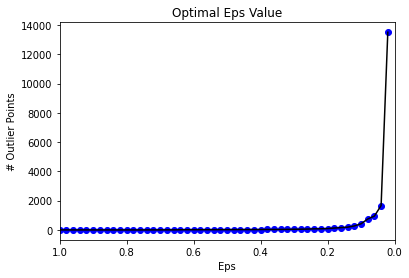

True

In [30]:
plotGraph(grap_x,graph_y)

## Apply DBSCAN

In [31]:
def findinterval(time,file):
        f2 = open(file, "r")
        for x in f2:
            line=x.split()
            tripId=line[1]

            datee=line[2]
            datee=datee.split("-")
            start_time=line[3].split(":")
            general_start_time_obj=datetime(int(datee[0]),int(datee[1]),int(datee[2]),int(start_time[0]),int(start_time[1]),int(start_time[2]))

            finish_time=line[5].split(":")
            finish_epoch=datetime(int(datee[0]),int(datee[1]),int(datee[2]),int(finish_time[0]),int(finish_time[1]),int(finish_time[2]))

            if(time>=general_start_time_obj and time<=finish_epoch):
                return tripId
        return False

In [32]:
analyse_number=0
possible_outliers=[]
input_txt_file="real_result1.txt"

while True:
    if(str(analyse_number+1) in analyse_points):
        # cluster
            cluster_result=clusterPoints(analyse_points[str(analyse_number+1)],0.04,47)
            #print(cluster_result)
            for out in range(len(cluster_result)):
                if cluster_result[out]==-1:
                    #print(analyse_points["info"+str(analyse_number+1)][out][2])
                    tripId=findinterval(analyse_points["info"+str(analyse_number+1)][out][2],input_txt_file)
                    if(tripId!=False):
                        possible_outliers.append(dict({"part":analyse_number+1,"point":analyse_points["info"+str(analyse_number+1)][out],"tripId":str(tripId)}))
            analyse_number=analyse_number+1
    else:
        break
print(len(possible_outliers))

1662


In [33]:
import csv

with open('real_result1.csv', mode='w') as csv_file:
    possible_outlers_fieldnames = ['part','tripId','time', 'lat', 'lon']
    writer = csv.DictWriter(csv_file, fieldnames=possible_outlers_fieldnames)
    writer.writeheader()
    for poss_outlier in possible_outliers:
        writer.writerow({'part':poss_outlier["part"],'tripId':poss_outlier["tripId"],'time': poss_outlier["point"][2],'lat':poss_outlier["point"][1],'lon':poss_outlier["point"][0] })